<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

In [2]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Normalization
values = df[['% Silica Concentrate']].values

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values)

In [4]:
def create_data(series, prev_instances = 4):
 
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
        X_train_temp = X_train_temp.shift(1)
        data = pd.concat([X_train_temp, data], axis=1)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)
    # print(data.head(10))
    X = data.iloc[:, 0:-1].values 
    y = data.iloc[:,-1].values 
    
    print('This series takes {} previous instances'.format(prev_instances))
    
    data.columns = [*data.columns[:-1], 'y']
    
    return data, X, y

In [5]:
WINDOW_SIZE = 5

time_series = scaled_data;
data, X, y = create_data(time_series, prev_instances = WINDOW_SIZE)

This series takes 5 previous instances


In [6]:
# 70% 15% 15%

X_train, y_train = X[:2664], y[:2664]
X_test, y_test = X[2664:3235], y[2664:3235]
X_val, y_val = X[3235:], y[3235:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2664, 5), (2664,), (571, 5), (571,), (565, 5), (565,))

In [7]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Forecasting with XGBOOST

In [ ]:
from math import sqrt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE

sweep_xgboost_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "MAPE",
      "goal": "minimize"   
    },
    "parameters": {
        "booster": {
            "values": ["gbtree","gblinear"]
        },
        "max_depth": {
            "values": [ 7, 9, 12]
        },
        "n_estimators": {
            "values": [50, 100, 200]
        },
        "learning_rate": {
            "values": [0.01, 0.025]
        },
        "subsample": {
            "values": [1, 0.5, 0.3]
        },
        "colsample_bytree": {
            "values": [0.3, 0.7]
        }
    }
}

sweep_xgboost_id = wandb.sweep(sweep_xgboost_config, project="XGBoost_shot_3")

def xgboost_train():
  config_defaults = {
      'n_estimators': 200,
      "booster": "gbtree",
      "max_depth": 3,
      "learning_rate": 0.1,
    }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  model = XGBRegressor(n_estimators = config.n_estimators,
                      booster = config.booster,
                      max_depth = config.max_depth,
                      learning_rate = config.learning_rate,
                      objective ='reg:squarederror',
                      verbosity = 0)

  model.fit(X_train, y_train)

  predictions_test = model.predict(X_test)
  mape, mae, rmse = forecast_accuracy(y_test, predictions_test)
  print(mape, mae, rmse)

  wandb.log({"MAPE": mape})

wandb.agent(sweep_xgboost_id, xgboost_train, count=40)

In [15]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators = 200,
                     max_depth = 7,
                     booster='gbtree',
                     learning_rate = 0.01,
                     colsample_bytree = 0.7,
                     objective ='reg:squarederror',
                     verbosity = 0)
model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

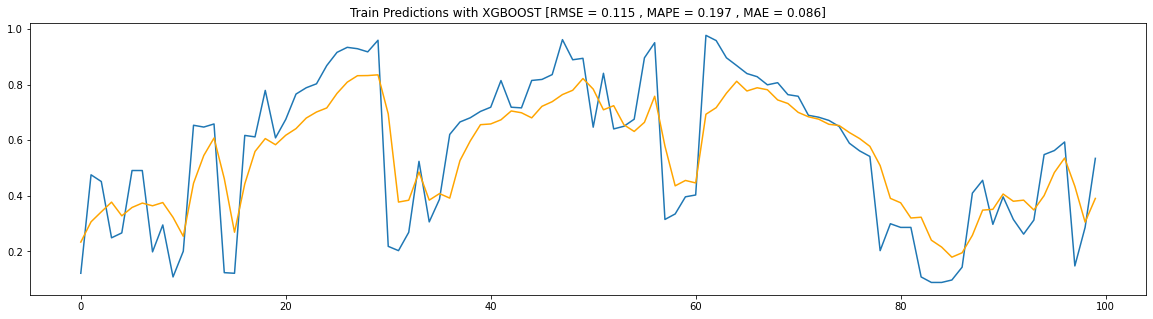

In [16]:
from matplotlib import pyplot
mape, mae, rmse = forecast_accuracy(y_train, predictions_train)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(y_train[0:100])
pyplot.plot(predictions_train[0:100], color='orange')
plt.title("Train Predictions with XGBOOST [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

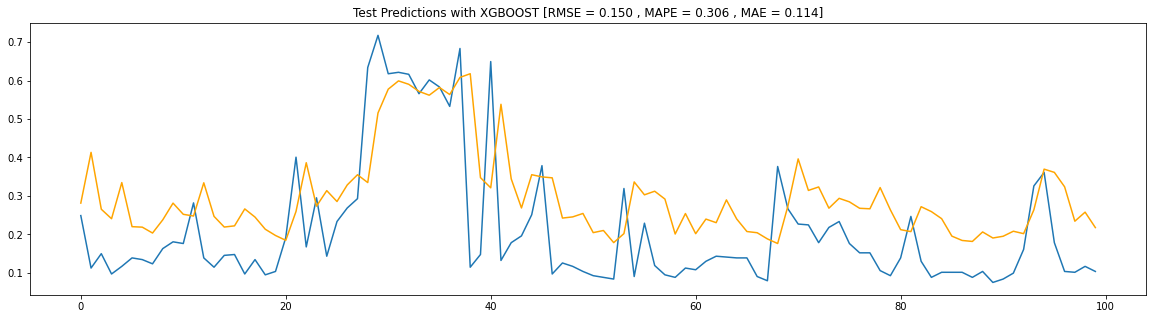

In [17]:
mape, mae, rmse = forecast_accuracy(y_test, predictions_test)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(y_test[0:100])
pyplot.plot(predictions_test[0:100], color='orange')
plt.title("Test Predictions with XGBOOST [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

## Forecasting with RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

sweep_rf_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "MAPE",
      "goal": "minimize"   
    },
    "parameters": {
        "max_depth": {
            "values": [2, 3, 6, 7, 9, 12]
        },
        "n_estimators": {
            "values": [50, 100, 200]
        },
        
        "max_features": {
            "values": ['auto']
        },
        "min_samples_split": {
            "values": [3, 5, 7]
        }
    }
}

sweep_rf_id = wandb.sweep(sweep_rf_config, project="RandomForest")

def rf_train():
  config_defaults = {
      'n_estimators': 200,
      "max_depth": 3,
      "max_features": 'auto',
      "min_samples_split": 3
    }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  model = RandomForestRegressor(n_estimators = config.n_estimators,
                                max_depth = config.max_depth,
                                min_samples_split = config.min_samples_split,
                                max_features= config.max_features)

  model.fit(X_train, y_train)

  predictions_test = model.predict(X_test)
  mape, mae, rmse = forecast_accuracy(y_test, predictions_test)
  print(mape, mae, rmse)

  wandb.log({"MAPE": mape})

wandb.agent(sweep_rf_id, rf_train, count=40)

In [18]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50,
                              max_features='auto',
                              min_samples_split = 5,
                              max_depth = 7)

model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

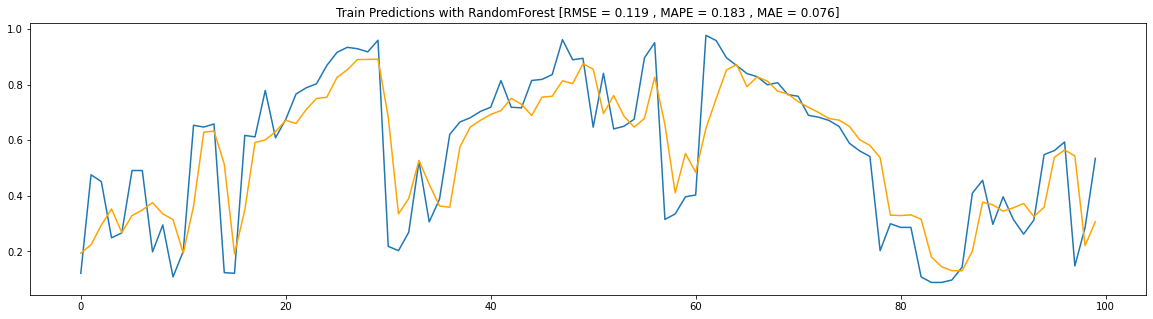

In [19]:
mape, mae, rmse = forecast_accuracy(y_train, predictions_train)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(y_train[0:100])
pyplot.plot(predictions_train[0:100], color='orange')
plt.title("Train Predictions with RandomForest [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

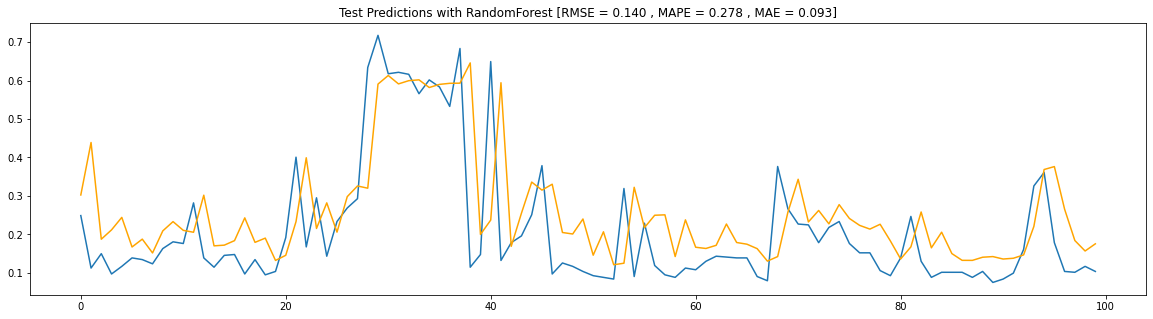

In [20]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

mape, mae, rmse = forecast_accuracy(y_test, predictions_test)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(y_test[0:100])
pyplot.plot(predictions_test[0:100], color='orange')
plt.title("Test Predictions with RandomForest [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()